In [2]:
import pandas as pd
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature

# load station data
# rough boundaries for downtown Toronto
bbox_dt = [(43.665157, -79.411268), 
           (43.634167, -79.396763), 
          (43.651062, -79.347153),
          (43.675527, -79.361652)];

polygon = Polygon(
    [
        bbox_dt
    ]
)

# find all the stations in downtown Toronto
stations_df = pd.read_csv('stations.csv', index_col=0)
not_in_dt_station_list = []
total_num_stations = stations_df.shape[0]
for index, row in stations_df.iterrows():
    point = Feature(geometry=Point((row.lat, row.lon)))
    if not boolean_point_in_polygon(point, polygon):
        not_in_dt_station_list.append(index)
stations_df.drop(not_in_dt_station_list, axis=0, inplace=True)
stations_df.reset_index()
print("number of bike stations in downtown Toronto: ", total_num_stations - len(not_in_dt_station_list))
stations_df.reset_index(drop=True, inplace=True)
stations_df
stations = stations_df

number of bike stations in downtown Toronto:  220


In [3]:
# load ridership data
ridership_df = pd.read_csv('ridership.csv')
ridership_df

Unnamed: 0        start_time          end_time  startSID  endSID   BID
0                0  09/01/2022 00:00  09/01/2022 00:08      7155  7256.0  5458
1                1  09/01/2022 00:00  09/01/2022 00:05      7245  7069.0  6241
2                2  09/01/2022 00:00  09/01/2022 00:05      7060  7270.0  4393
3                3  09/01/2022 00:00  09/01/2022 00:20      7204  7430.0  5298
4                4  09/01/2022 00:00  09/01/2022 00:10      7417  7026.0  5756
...            ...               ...               ...       ...     ...   ...
602662      602662  09/30/2022 23:59  10/01/2022 00:03      7654  7466.0  6443
602663      602663  09/30/2022 23:59  10/01/2022 00:34      7199  7581.0  2258
602664      602664  09/30/2022 23:59  10/01/2022 00:12      7548  7458.0  4978
602665      602665  09/30/2022 23:59  10/01/2022 00:21      7016  7079.0  6407
602666      602666  09/30/2022 23:59  10/01/2022 00:25      7074  7160.0  5244

[602667 rows x 6 columns]

In [4]:
# import librairies
import numpy as np
import pandas as pd
import time 
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16,13]

In [5]:
data = pd.read_csv('ridership.csv', parse_dates = ['start_time', 'end_time'], dayfirst=True, index_col=0)
data.endSID = data.endSID.astype(int)
data

start_time            end_time  startSID  endSID   BID
0      2022-01-09 00:00:00 2022-01-09 00:08:00      7155    7256  5458
1      2022-01-09 00:00:00 2022-01-09 00:05:00      7245    7069  6241
2      2022-01-09 00:00:00 2022-01-09 00:05:00      7060    7270  4393
3      2022-01-09 00:00:00 2022-01-09 00:20:00      7204    7430  5298
4      2022-01-09 00:00:00 2022-01-09 00:10:00      7417    7026  5756
...                    ...                 ...       ...     ...   ...
602662 2022-09-30 23:59:00 2022-01-10 00:03:00      7654    7466  6443
602663 2022-09-30 23:59:00 2022-01-10 00:34:00      7199    7581  2258
602664 2022-09-30 23:59:00 2022-01-10 00:12:00      7548    7458  4978
602665 2022-09-30 23:59:00 2022-01-10 00:21:00      7016    7079  6407
602666 2022-09-30 23:59:00 2022-01-10 00:25:00      7074    7160  5244

[602667 rows x 5 columns]

In [6]:
stations = stations_df
stations['station_id'] = stations.station_id.astype(int)
checkSID_series = data.startSID.isin(stations['station_id'])
checkSID_series_end = data.endSID.isin(stations['station_id'])
check_data = pd.concat([checkSID_series, checkSID_series_end])
check_data
remove_list = set()
for index, value in check_data.items():
    if value == False:
        if index not in remove_list:
            remove_list.add(index)
len(remove_list)

323168

In [7]:
# delete 323168 ridership rows with invalid bike station info
data.drop(remove_list, axis=0, inplace=True)
data.reset_index(inplace=True, drop=True)
data

start_time            end_time  startSID  endSID   BID
0      2022-01-09 00:00:00 2022-01-09 00:08:00      7155    7256  5458
1      2022-01-09 00:00:00 2022-01-09 00:05:00      7060    7270  4393
2      2022-01-09 00:00:00 2022-01-09 00:10:00      7417    7026  5756
3      2022-01-09 00:00:00 2022-01-09 00:06:00      7030    7007  3443
4      2022-01-09 00:00:00 2022-01-09 00:12:00      7491    7281  5903
...                    ...                 ...       ...     ...   ...
279494 2022-09-30 23:58:00 2022-01-10 00:14:00      7257    7257  5943
279495 2022-09-30 23:58:00 2022-01-10 00:06:00      7391    7374   232
279496 2022-09-30 23:58:00 2022-01-10 00:06:00      7033    7043  6138
279497 2022-09-30 23:59:00 2022-01-10 00:12:00      7548    7458  4978
279498 2022-09-30 23:59:00 2022-01-10 00:21:00      7016    7079  6407

[279499 rows x 5 columns]

In [8]:
from sklearn.cluster import KMeans
X = stations[['lon', 'lat']].values
n_clusters_ = 19
kmeans = KMeans(n_clusters = n_clusters_, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.
labels = kmeans.fit_predict(X)

In [9]:
# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 

# map each station with its region
stations['cluster']=labels
stations.index=stations['station_id']
cluster_map = stations['cluster'].to_dict()
data['from_station_c']=data['startSID'].map(cluster_map)
data['to_station_c']=data['endSID'].map(cluster_map)


In [10]:
import matplotlib.image as mpimg
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
# BBox = (-79.4900,-79.2700,43.6100,43.7200)
# map_tor = mpimg.imread('map.png')
fig, ax = plt.subplots()
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)
    ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
    ax.text(centers[k, 0], centers[k, 1], k,fontsize=12)
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
plt.show()


In [11]:
import folium
stations1 = stations.copy()
stations1.reset_index(drop=True, inplace=True)

locations = stations1[['lat', 'lon']]
locationlist = locations.values.tolist()
color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
map = folium.Map(location=[43.657366, -79.378528], zoom_start=14)
for point in range(0, len(locationlist)):
    if locationlist[point]== [0.0, 0.0]: continue
    folium.Marker(locationlist[point], icon=folium.Icon(color=color_list[stations1['cluster'][point]],icon='map-marker', prefix='fa'), popup=stations1['cluster'][point]).add_to(map)
map



In [12]:
df = data
df['from_station_id'] = data['startSID']
df['to_station_id'] = data['endSID']
df['region_count']=(df['from_station_c']<df['to_station_c']).astype(int)-(df['from_station_c']>df['to_station_c']).astype(int)
df['region_key'] = df[['from_station_c','to_station_c']].min(axis=1).astype('str') +'_'+ df[['from_station_c','to_station_c']].max(axis=1).astype('str')

df['station_count']=(df['from_station_id']<df['to_station_id']).astype(int)-(df['from_station_id']>df['to_station_id']).astype(int)
df['station_key'] = df[['from_station_id','to_station_id']].min(axis=1).astype('str') +'_'+ df[['from_station_id','to_station_id']].max(axis=1).astype('str')
# Hour of the day
df['hour'] = df['start_time'].dt.hour
# Day of the week
df['dayofweek'] = df['start_time'].dt.dayofweek
# Date
df['date'] = df['start_time'].dt.floor('d')

df.describe(include=['O'])
df.columns

Index(['start_time', 'end_time', 'startSID', 'endSID', 'BID', 'from_station_c',
       'to_station_c', 'from_station_id', 'to_station_id', 'region_count',
       'region_key', 'station_count', 'station_key', 'hour', 'dayofweek',
       'date'],
      dtype='object')

In [13]:
##############################
# Extract flows and create graph
##############################

def getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4,5,6]):
    # flows
    if region:
        flows = df.loc[(df['from_station_c']!=df['to_station_c'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['region_key'])['region_count'].sum()
    else:
        flows = df.loc[(df['from_station_id']!=df['to_station_id'])&(df['dayofweek'].isin(days)) & (df['date']>=start_date) & (df['date']<end_date) ].groupby(['station_key'])['station_count'].sum()
    # graph
    G = nx.DiGraph()
    for index, value in flows.items():
        G.add_weighted_edges_from([(int(index.split('_')[0]), int(index.split('_')[1]), value)])
    # degrees of each nodes
    nodes=[]
    degrees=[]
    for e in G:
        nodes.append(e)
        degrees.append(G.in_degree(e, weight='weight')-G.out_degree(e, weight='weight'))
    deg = pd.Series(data=degrees,index=nodes).sort_values()
    return flows,G,deg

f_stations_w, g_stations_w , d_stations_w = getFlows(region=False,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4])
f_stations_we, g_stations_we , d_stations_we = getFlows(region=False,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [5,6])
f_regions_w, g_regions_w , d_regions_w = getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [0,1,2,3,4])
f_regions_we, g_regions_we , d_regions_we = getFlows(region=True,start_date=pd.Timestamp('2022-01-01'),end_date=pd.Timestamp('2023-01-01'),days = [5,6])

In [14]:
top10 = pd.DataFrame(np.vstack([d_stations_w.iloc[:10].index.values,d_stations_w.iloc[-10:].index.values,d_stations_we.iloc[:10].index.values,d_stations_we.iloc[-10:].index.values]).transpose()
                                     ,columns=["Negative_Week","Positive_Week","Negative_Weekend","Positive_Weekend"])
station_name_dict = pd.Series(stations.name.values,index=stations.station_id).to_dict()
top10["Negative_Week"] = top10["Negative_Week"].map(station_name_dict)
top10["Positive_Week"] = top10["Positive_Week"].map(station_name_dict)
top10["Negative_Weekend"] = top10["Negative_Weekend"].map(station_name_dict)
top10["Positive_Weekend"] = top10["Positive_Weekend"].map(station_name_dict)

top10

Negative_Week  \
0                       Bay St / Wellesley St W   
1                      Dundonald St / Church St   
2                      Adelaide St W / Brant St   
3                Sherbourne St / Wellesley St E   
4              Spadina Ave / Sussex Ave - SMART   
5                       Isabella St / Church St   
6  The Royal Ontario Museum (Bloor St Entrance)   
7  University Ave / Gerrard St W (WEST) - SMART   
8                   Ted Rogers Way / Bloor St E   
9                  Willcocks St / St. George St   

                                 Positive_Week  \
0                       Simcoe St / Queen St W   
1                        College St / Major St   
2                     HTO Park (Queens Quay W)   
3                      Phoebe St / Spadina Ave   
4                         Soho St / Queen St W   
5  Front St W / Yonge St (Hockey Hall of Fame)   
6                     Wellington St W / Bay St   
7    University Ave / Gerrard St W (East Side)   
8                                Union Station   
9               King St W / Bay St (West Side)   

                               Negative_Weekend  \
0                       Bay St / Wellesley St W   
1                      Dundonald St / Church St   
2                Sherbourne St / Wellesley St E   
3                               20 Charles St E   
4                      Adelaide St W / Brant St   
5                       Isabella St / Church St   
6                   Bay St / Charles St - SMART   
7              Spadina Ave / Sussex Ave - SMART   
8  The Royal Ontario Museum (Bloor St Entrance)   
9                       Jarvis St / Isabella St   

                              Positive_Weekend  
0                        King St E / Jarvis St  
1               Dundas St E / Regent Park Blvd  
2               Queens Quay W / Dan Leckie Way  
3                      York St / Queens Quay W  
4  Front St W / Yonge St (Hockey Hall of Fame)  
5                     Wellington St W / Bay St  
6                      Phoebe St / Spadina Ave  
7               King St W / Bay St (West Side)  
8                                Union Station  
9                     HTO Park (Queens Quay W)

In [15]:
############################################################
# Plot the graphs
############################################################
def plot_G_stations(G,degrees,ptitle=""):
    colors=[]
    pos={}
    node_sizes=[]
    max_deg = degrees.abs().max()
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 500*(abs(d)/max_deg))
        pos[int(e)]=(stations.loc[e,'lon'],stations.loc[e,'lat'])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')
    nx.draw_networkx_nodes(G,pos, node_size=node_sizes,node_color=colors)
    nx.draw_networkx_labels(G, pos,labels= labels, font_size=7)
    plt.title(ptitle)
    plt.show()



def plot_G_regions(G,flows,degrees,ptitle=""):
    colors=[]
    pos={}
    max_deg = degrees.abs().max()
    node_sizes=[]
    labels={}
    for e in G:
        d=degrees[e]
        node_sizes.append(100 + 600*(abs(d)/max_deg))
        pos[int(e)]=(centers[e,0],centers[e,1])
        labels[int(e)]=(int(d))
        if d==0:
            colors.append('#00aedb')
        elif d < 0:
            colors.append('#f37735')
        else: 
            colors.append('#00b159')

    color_cut_pos = flows[flows>0].median()
    color_cut_neg = flows[flows<0].median()

    elargepos = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >color_cut_pos]
    elargeneg = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < color_cut_neg]
    eother = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= color_cut_neg and d['weight'] <= color_cut_pos]

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,node_color=colors,alpha=0.9)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elargepos,edge_color='#00b159', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=elargeneg,edge_color='#f37735', width=4,alpha=0.7)
    nx.draw_networkx_edges(G, pos, edgelist=eother,edge_color='#00aedb', width=1,alpha=0.5)

    # labels
    nx.draw_networkx_labels(G, pos, labels= labels,font_size=14)
    plt.title(ptitle)
    plt.show()

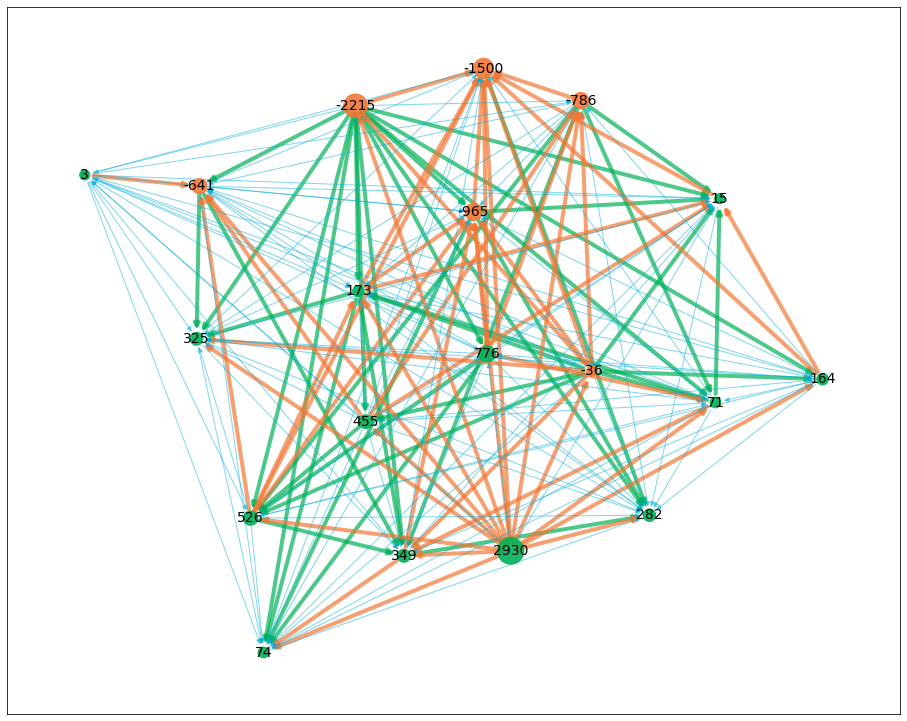

In [16]:
# weekdays
plot_G_regions(g_regions_w,f_regions_w,d_regions_w)

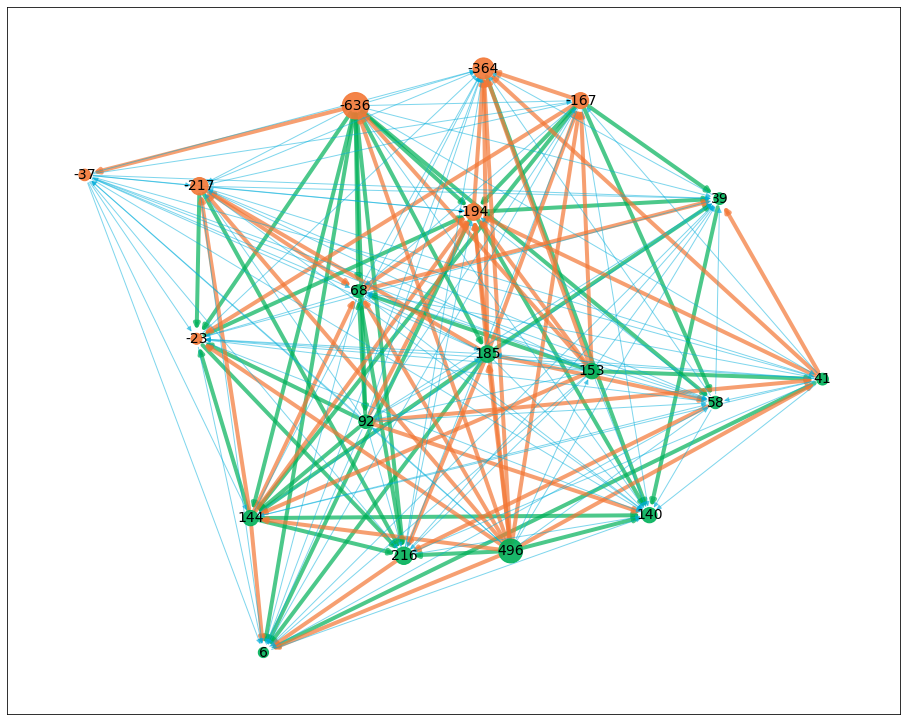

In [17]:
# weekends
plot_G_regions(g_regions_we,f_regions_we,d_regions_we)

In [18]:
plot_G_stations(g_stations_w,  d_stations_w)

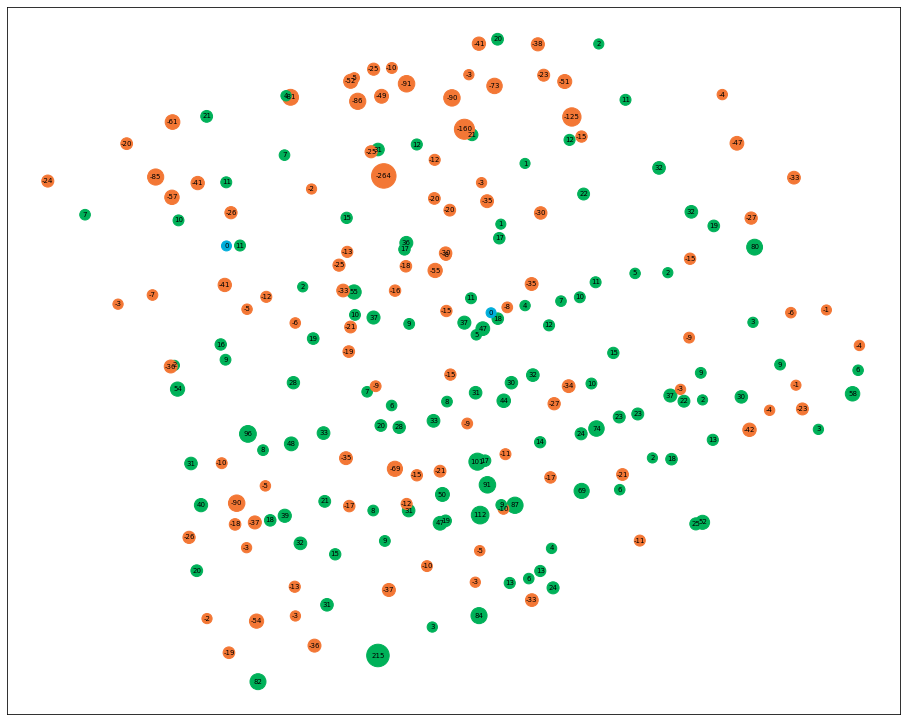

In [19]:
plot_G_stations(g_stations_we,  d_stations_we)

#### Next, we need to calculate the potential demand for each station.

In [20]:
import datetime as dt
start = df['start_time'].min().to_pydatetime()
end = df['start_time'].max().to_pydatetime()

weekdays = np.busday_count(start.date(), end.date())
days = (end.date() - start.date()).days
weekends = days - weekdays
print("There are ", days, " days, ", weekdays, " are weekdays and ", weekends, " are weekends.")

There are  334  days,  239  are weekdays and  95  are weekends.


In [21]:
# calculate the average offset for weekdays and weekends respectively
print("--- average bike offset on weekdays ---")
print(d_stations_w / weekdays)
print("\n--- average bike offset on weekends ---")
print(d_stations_we / weekends)

--- average bike offset on weekdays ---
7030   -3.677824
7024   -2.702929
7463   -1.476987
7042   -1.251046
7667   -1.251046
          ...   
7048    1.326360
7052    1.389121
7047    1.836820
7033    2.594142
7015    4.527197
Length: 220, dtype: float64

--- average bike offset on weekends ---
7030   -2.778947
7024   -1.684211
7042   -1.315789
7385   -0.957895
7463   -0.947368
          ...   
7052    0.957895
7020    1.010526
7015    1.063158
7033    1.178947
7175    2.263158
Length: 220, dtype: float64


In [22]:
# set absolute value of threashold to 1
thresh = 1
offset_w = d_stations_w / weekdays
nodes = []
for index, value in offset_w.items():
    if abs(value) >= thresh:
        nodes.append((index, value))
print(nodes, "\nTotal number of stations that needs to be rebalanced = ", len(nodes))

[(7030, -3.6778242677824267), (7024, -2.702928870292887), (7463, -1.4769874476987448), (7042, -1.2510460251046025), (7667, -1.2510460251046025), (7409, -1.1506276150627615), (7251, -1.100418410041841), (7634, -1.0794979079497908), (7025, -1.0543933054393306), (7066, -1.0334728033472804), (7022, 1.0), (7078, 1.0334728033472804), (7175, 1.0334728033472804), (7020, 1.0543933054393306), (7217, 1.1213389121338913), (7048, 1.3263598326359833), (7052, 1.389121338912134), (7047, 1.8368200836820083), (7033, 2.594142259414226), (7015, 4.527196652719665)] 
Total number of stations that needs to be rebalanced =  20


In [24]:
# run the ACO algorithm on the 20 stations with single vehicle

import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest
import matplotlib.pyplot as plt
import time

# Import location data
not_in_dt_depots = []
depots = pd.read_csv("depots.csv")
for index, row in depots.iterrows():
    point = Feature(geometry=Point((row.lat, row.lng)))
    if not boolean_point_in_polygon(point, polygon):
        not_in_dt_depots.append(index)
depots.drop(not_in_dt_depots, axis=0, inplace=True)
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
depots.reset_index(inplace=True, drop=True)
depots

address        lat        lng
0       533 King St W  43.644789 -79.398277
1       512 Church St  43.664656 -79.380577
2    65 Navy Wharf Ct  43.641382 -79.391432
3    35 The Esplanade  43.646443 -79.375100
4   249 Queens Quay W  43.638840 -79.385941
5  155 Wellesley St E  43.666518 -79.375275

In [93]:
# One correct way to approximate the demand for each bike station is to calculate the average number of bikes
# before the rebalancing every day/night. However, because the stations status API is on a real-time basis, we do not
# have the record of data across the same period of time. Thus, we are only using a temporary data in the midnight
# from the API to demonstrate a common status before rebalancing takes act. The data has a timestamp 1670993188 
# which converts to 
# Tue Dec 13 2022 23:46:28 GMT-0500 (Eastern Standard Time).

# Note that this is only done due to the shortage of necessary data.
# In this case, the demand gap is just the average offset on weekdays.
status = pd.read_json('stations_status.json').data.stations
status = pd.DataFrame(status)
status['station_id'] = status['station_id'].astype(int)
status
remove_list = set()
checkStatus = status.station_id.isin(stations['station_id'])
checkStatus
remove_list = set()
for index, value in checkStatus.items():
    if value == False:
        if index not in remove_list:
            remove_list.add(index)
len(remove_list)
status.drop(remove_list, inplace=True)
status.reset_index(drop=True, inplace=True)
status

station_id  num_bikes_available       num_bikes_available_types  \
0          7000                   21  {'mechanical': 21, 'ebike': 0}   
1          7001                    6   {'mechanical': 6, 'ebike': 0}   
2          7002                    0   {'mechanical': 0, 'ebike': 0}   
3          7004                    0   {'mechanical': 0, 'ebike': 0}   
4          7005                    4   {'mechanical': 4, 'ebike': 0}   
..          ...                  ...                             ...   
213        7718                    9   {'mechanical': 9, 'ebike': 0}   
214        7719                   24  {'mechanical': 24, 'ebike': 0}   
215        7720                   13  {'mechanical': 13, 'ebike': 0}   
216        7721                    6   {'mechanical': 6, 'ebike': 0}   
217        7724                    4   {'mechanical': 4, 'ebike': 0}   

     num_bikes_disabled  num_docks_available  num_docks_disabled  \
0                     0                   14                   0   
1                     0                   20                   0   
2                     1                   17                   0   
3                     0                   11                   0   
4                     4                   11                   0   
..                  ...                  ...                 ...   
213                   1                    1                   0   
214                   1                    2                   1   
215                   2                    1                   0   
216                   2                    0                   0   
217                   0                   11                   0   

     last_reported  is_charging_station      status  is_installed  is_renting  \
0     1.670993e+09                False  IN_SERVICE             1           1   
1     1.670993e+09                 True  IN_SERVICE             1           1   
2     1.670993e+09                False  IN_SERVICE             1           1   
3     1.670993e+09                False  IN_SERVICE             1           1   
4     1.670993e+09                False  IN_SERVICE             1           1   
..             ...                  ...         ...           ...         ...   
213   1.670993e+09                False  IN_SERVICE             1           1   
214   1.670993e+09                False  IN_SERVICE             1           1   
215   1.670992e+09                False  IN_SERVICE             1           1   
216   1.670993e+09                False  IN_SERVICE             1           1   
217   1.670993e+09                False  IN_SERVICE             1           1   

     is_returning traffic  
0               1    None  
1               1    None  
2               1    None  
3               1    None  
4               1    None  
..            ...     ...  
213             1    None  
214             1    None  
215             1    None  
216             1    None  
217             1    None  

[218 rows x 13 columns]

In [135]:
status_list = list(status['station_id'])
remove_list = []
for i, j in nodes:
    if i not in status_list:
        remove_list.append(i)
print("number of stations that have missing status info: ", len(remove_list))

# find number of bikes available for the chosen stations
nodes_status = pd.DataFrame(columns = ['station_id', 'capacity', 'num_available', 'offset'])
for i, row in status.iterrows():
    for j, val in nodes:
        if int(row.station_id) == int(j):
            for k, station in stations.iterrows():
                if int(station.station_id) == int(j):
                    new_data = {'station_id' : int(row.station_id), 
                                'capacity' :  int(station.capacity),
                                'num_available' : int(row.num_bikes_available),
                                'offset': d_stations_w[j] / weekdays}
                    new_df = pd.DataFrame([new_data])
                    nodes_status = pd.concat([nodes_status, new_df], axis=0, ignore_index=True)
                    break

nodes_status

number of stations that have missing status info:  0


station_id capacity num_available    offset
0        7015       39            19  4.527197
1        7020       33             0  1.054393
2        7022       39            13       1.0
3        7024       36             7 -2.702929
4        7025       19            18 -1.054393
5        7030       51            22 -3.677824
6        7033       42             9  2.594142
7        7042       31            10 -1.251046
8        7047       25             0   1.83682
9        7048       47            14   1.32636
10       7052       27             7  1.389121
11       7066       17             0 -1.033473
12       7078       11             4  1.033473
13       7175       27            26  1.033473
14       7217       19             6  1.121339
15       7251       19             0 -1.100418
16       7409       19             1 -1.150628
17       7463       16            12 -1.476987
18       7634       18             3 -1.079498
19       7667       35             1 -1.251046

It seems like a better idea to use offset as a weighted value to set the demand for each station.

In [153]:
# approximate demand
demand_list = []
gap_list = []
upperbound = 4.0
lowerbound = 3.5
for i, row in nodes_status.iterrows():
    # a positive offset means ridership often ends at this station, so the demand is low
    if row.offset > 1:
        demand = round(max(0, row.capacity / 2.0 - (row.offset - 1) / (upperbound - 1) * row.capacity / 2.0))
    # a negative offset means ridership often starts from this station, so the demand is high
    if row.offset < -1:
        demand = round(min(row.capacity, row.capacity / 2.0 -  (row.offset + 1) / (lowerbound - 1) * row.capacity / 2.0))
    gap_list.append(demand - row.num_available)
    demand_list.append(demand)
nodes_status['demand'] = demand_list
nodes_status['gap'] = gap_list
nodes_status

station_id capacity num_available    offset  demand  gap
0        7015       39            19  4.527197       0  -19
1        7020       33             0  1.054393      16   16
2        7022       39            13       1.0      16    3
3        7024       36             7 -2.702929      30   23
4        7025       19            18 -1.054393      10   -8
5        7030       51            22 -3.677824      51   29
6        7033       42             9  2.594142      10    1
7        7042       31            10 -1.251046      17    7
8        7047       25             0   1.83682       9    9
9        7048       47            14   1.32636      21    7
10       7052       27             7  1.389121      12    5
11       7066       17             0 -1.033473       9    9
12       7078       11             4  1.033473       5    1
13       7175       27            26  1.033473      13  -13
14       7217       19             6  1.121339       9    3
15       7251       19             0 -1.100418      10   10
16       7409       19             1 -1.150628      10    9
17       7463       16            12 -1.476987      10   -2
18       7634       18             3 -1.079498       9    6
19       7667       35             1 -1.251046      19   18

In [160]:
# now that we have the proposd demand gap for each station, we can start optimizing the route planning to fill each gap.

# generate distance matrix
import pandas as pd
import requests # to get the distances from the API
import json # to read the API response
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose # for travelling salesman problem
import datetime

def get_distance(point1: dict, point2: dict) -> tuple:
    """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""
    
    url = f"""http://router.project-osrm.org/route/v1/driving/{point1["lon"]},{point1["lat"]};{point2["lon"]},{point2["lat"]}?overview=false&alternatives=false"""
    r = requests.get(url)
    
    # get the distance from the returned values
    route = json.loads(r.content)["routes"][0]
    return (route["distance"], route["duration"])

point1 = {"lat": 43.652867, "lon": -79.389753}
point2 = {"lat": 43.645197,  "lon": -79.395932}
dist, duration = get_distance(point1, point2)

In [180]:
# generate distance matrix
_nodes = [(stations['lat'][i], stations['lon'][i]) for i, _ in nodes]
_nodes
distance_matrix = [ [0]*len(_nodes) for i in range(len(_nodes))]
for i in range(len(_nodes)):
    for j in range(i + 1, len(_nodes)):
        point1 = {"lat": _nodes[i][0], "lon": _nodes[i][1]}
        point2 = {"lat": _nodes[j][0],  "lon": _nodes[j][1]}
        distance = get_driving_distance(point1, point2)
        distance_matrix[i][j] = distance_matrix[j][i] = distance
        print(i, j, distance)
print(distance_matrix)

0 1 680.3
0 2 3445.7
0 3 1153.8
0 4 1758
0 5 835.2
0 6 949.2
0 7 1003
0 8 1355.9
0 9 1446.6
0 10 1870.9
0 11 1822.9
0 12 3629.1
0 13 2759
0 14 2366.5
0 15 2225.4
0 16 1990.9
0 17 1002.8
0 18 2395.8
0 19 1849.2
1 2 4091.2
1 3 1298.5
1 4 2339.2
1 5 774.4
1 6 1530.5
1 7 1750.4
1 8 1298.3
1 9 2027.9
1 10 2516.5
1 11 2468.4
1 12 4274.6
1 13 3404.5
1 14 3012
1 15 2871
1 16 2636.5
1 17 1648.3
1 18 3041.3
1 19 2494.7
2 3 4181
2 4 2641.6
2 5 3862.4
2 6 3324.6
2 7 2147.7
2 8 4383.1
2 9 2124
2 10 1156.2
2 11 1721
2 12 1874.2
2 13 563.2
2 14 647.7
2 15 1959.7
2 16 1710.2
2 17 2032.2
2 18 1756.7
2 19 1495.6
3 4 2847.5
3 5 1488.1
3 6 2038.7
3 7 2258.6
3 8 963.1
3 9 2536.1
3 10 3024.7
3 11 2976.7
3 12 4782.9
3 13 3912.7
3 14 3520.2
3 15 3379.2
3 16 3144.7
3 17 2156.6
3 18 3549.5
3 19 3003
4 5 2344.7
4 6 1424.7
4 7 1715.4
4 8 2552.6
4 9 678.1
4 10 2615.5
4 11 1006.7
4 12 3788.9
4 13 2015.1
4 14 2099.7
4 15 3874.4
4 16 3501.4
4 17 1797.1
4 18 3671.4
4 19 3277.5
5 6 1195.5
5 7 1988.7
5 8 523.9
5 9 2266.

In [183]:
import pickle
pickle.dump(distance_matrix, open('distance', 'wb'))
# distance_matrix = pickle.load(open('distance', 'rb'))

[(43.664088, -79.387095), (43.66663, -79.38148), (43.6462574, -79.3973381), (43.6673, -79.374), (43.66402799999999, -79.40297869999999), (43.66834, -79.38235), (43.668372, -79.393586), (43.6578449, -79.3899265), (43.671293, -79.380471), (43.662085, -79.397735), (43.65049, -79.3873), (43.6576, -79.4032), (43.63796, -79.387502), (43.650033, -79.396555), (43.6494896, -79.393535), (43.646144, -79.377962), (43.647259, -79.379878), (43.657763, -79.389165), (43.645609, -79.380386), (43.64852, -79.380576)]
Started : ACS
Ended : ACS
Sequence : <- 16 - 17 - 20 - 19 - 11 - 8 - 18 - 1 - 2 - 9 - 6 - 4 - 7 - 10 - 5 - 12 - 3 - 15 - 14 - 13 ->
Total distance travelled to complete the tour : 20070.8



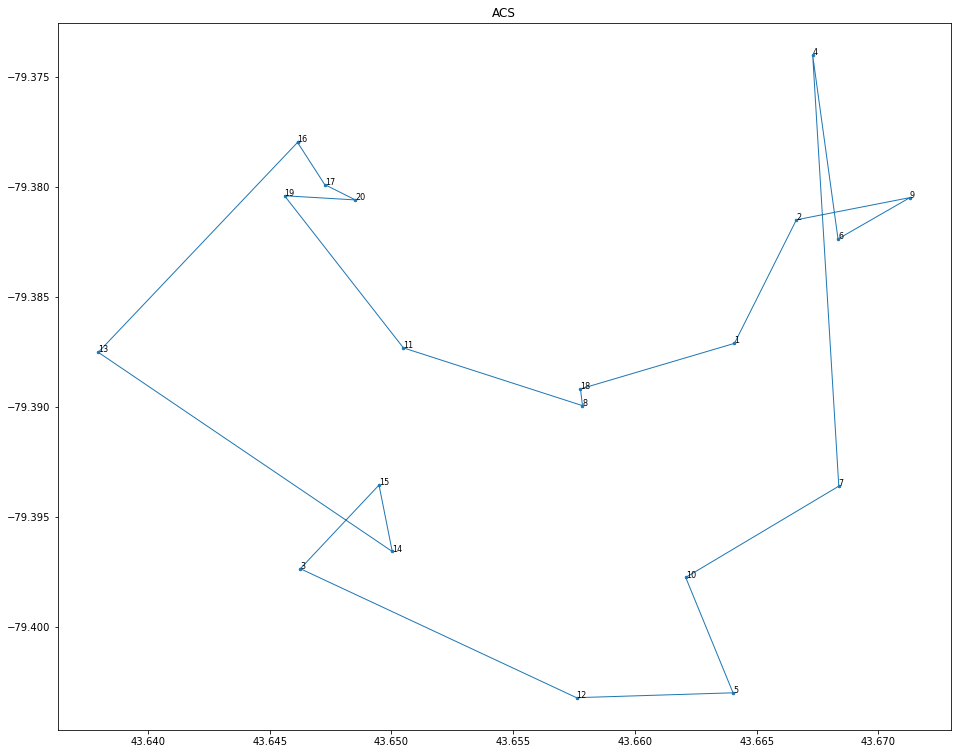

Started : Elitist
Ended : Elitist
Sequence : <- 2 - 6 - 9 - 7 - 10 - 5 - 12 - 14 - 3 - 15 - 11 - 20 - 16 - 19 - 13 - 17 - 18 - 8 - 1 - 4 ->
Total distance travelled to complete the tour : 18958.8



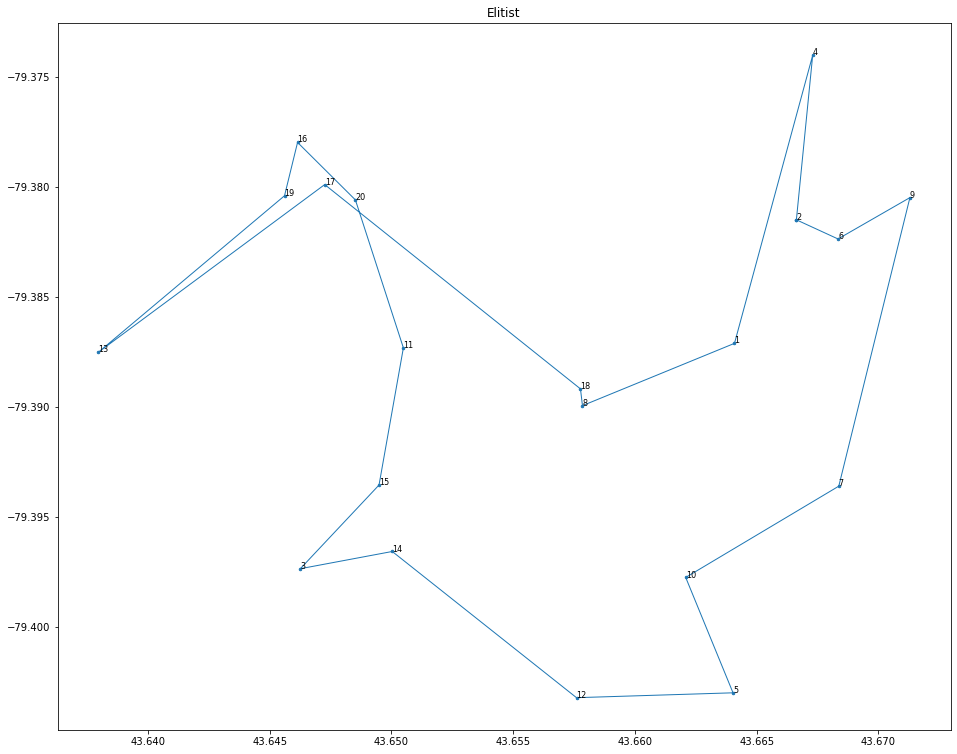

Started : MaxMin
Ended : MaxMin
Sequence : <- 17 - 20 - 11 - 8 - 18 - 1 - 2 - 6 - 9 - 4 - 7 - 10 - 5 - 12 - 14 - 3 - 15 - 13 - 19 - 16 ->
Total distance travelled to complete the tour : 18096.2



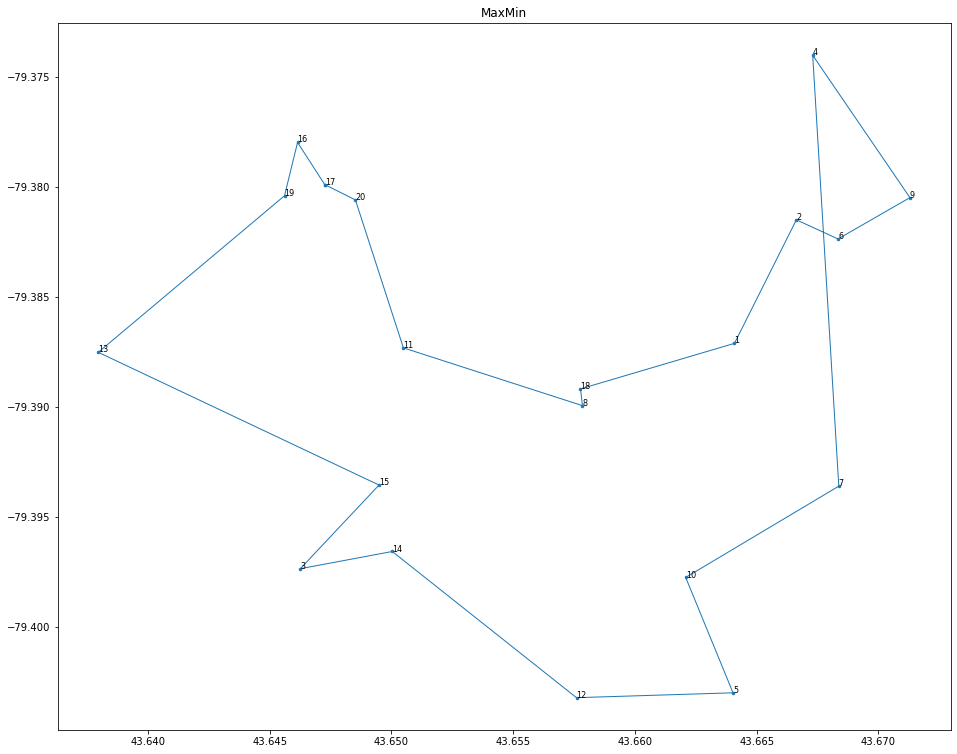

<Figure size 1152x936 with 0 Axes>

In [190]:
# dxd to do: Unfinished from here

import math
import random
from matplotlib import pyplot as plt

def get_driving_distance(point1: dict, point2: dict) -> tuple:
        """Gets distance between two points en route using http://project-osrm.org/docs/v5.10.0/api/#nearest-service"""

        url = f"""http://router.project-osrm.org/route/v1/driving/{point1["lon"]},{point1["lat"]};{point2["lon"]},{point2["lat"]}?overview=false&alternatives=false"""
        r = requests.get(url)

        # get the distance from the returned values
        route = json.loads(r.content)["routes"][0]
        return route["distance"]#, route["duration"])
class SolveTSPUsingACO: # ref: https://github.com/rochakgupta/aco-tsp/blob/master/aco_tsp.py
   
            

    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0
            
        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance


    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                point1 = {"lat": self.nodes[i][0], "lon": self.nodes[i][1]}
                point2 = {"lat": self.nodes[j][0],  "lon": self.nodes[j][1]}
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, 
                                                                distance_matrix[i][j],
                                                                #math.sqrt(pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        print('Started : {0}'.format(self.mode))
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
        print('Ended : {0}'.format(self.mode))
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2))),

    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width)
        plt.scatter(x, y, s=math.pi * (point_radius ** 2.0))
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size)
        if save:
            if name is None:
                name = '{0}.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    _colony_size = 5
    _steps = 50
#     _nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 15)]
    _nodes = [(stations['lat'][i], stations['lon'][i]) for i, _ in nodes]
    print(_nodes)
    acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    elitist.run()
    elitist.plot()
    max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    max_min.run()
    max_min.plot()

In [150]:
# dxd to do : copied from Assignment3, needs to be modified
# 1. remove depots?
# 2. delete dropoffs
# 3. generate new trip matrix for the 20 nodes
# 4. add weight of the rebalancing task based on the solution to the fitness function

pickups = pd.read_csv("carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

# Import a pre-calculated trip distance matrix
# These distances are based off of an osrm routing
tm = pd.read_csv("trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]
        
        
class CarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        pre_avoid = [],
        post_avoid = [],
        ############### START NEW CODE ################
        isAdaptive = False,
        mutation_const = 0
        ############### END NEW CODE ##################
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        ############### START NEW CODE ################
        self.isAdaptive = isAdaptive
        self.mutation_const = mutation_const
        ############### END NEW CODE ##################

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        # set initial mutation probability 
        ################## START NEW CODE ####################
        sig = 0.5
        mutation_lst = []
        max_mutation = 0
        ################## END NEW CODE ####################
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            self.states.append(max(self.costs))            
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(CarSharingSolver.crossover(p1,p2))
                    offspring.append(CarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < self.mutation_prob:
                    new_population.append(CarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    
        
        


In [ ]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

# run the solver
solver = CarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes, 
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
solver.initial_population()
solver.run()

# Visualize the graph
solver.visualize_graph()